<font size="3">**1. 数据处理**</font>

In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
#user数据
unames = ['user_id', 'age', 'gender', 'occupation' ,'zip'] #zip为邮政编码
users = pd.read_table('data/u.user', sep = '|', header = None, names = unames)
users.head(5)

,user_id,age,gender,occupation,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [3]:
#电影数据
mnames = ['item_id', 'title', 'release_date', 'video_release_date','url', 'unknown', 
          'Action', 'Adventure', 'Animation','Children', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery','Romance', 
          'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_table('data/u.item', sep = '|', header = None, names = mnames, encoding = 'ISO-8859-1')
movies = movies.drop('video_release_date', axis=1)
movies.head(5)

,item_id,title,release_date,url,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
#评分数据
rnames = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_table('data/u.data', sep='\t', header = None, names = rnames)
ratings.head(5)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
#dataframe拼接
data = pd.merge(ratings, users, on='user_id', how = 'left')
data = pd.merge(data, movies, on = 'item_id', how = 'left')

In [6]:
#时间戳处理
data['timestamp'] = pd.to_datetime(data['timestamp'], unit = 's')

#年龄分桶
bins = [0, 18, 30, 45, 60, 100]  # 设定分桶的边界
labels = [0, 1, 2, 3, 4]  # 每个区间的标签
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

#性别编码
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

#职业编码
occupation_code = {'administrator': 0,
    'artist': 1,
    'doctor': 2,
    'educator': 3,
    'engineer': 4,
    'entertainment': 5,
    'executive': 6,
    'healthcare': 7,
    'homemaker': 8,
    'lawyer': 9,
    'librarian': 10,
    'marketing': 11,
    'none': 12,
    'other': 13,
    'programmer': 14,
    'retired': 15,
    'salesman': 16,
    'scientist': 17,
    'student': 18,
    'technician': 19,
    'writer': 20}
data['occupation'] = data['occupation'].map(occupation_code)

#邮政编码保留前3位
data['zip'] = data['zip'].apply(lambda zip : str(zip)[:3]).astype(str)

#发行时间日期格式统一
data['release_date'] = pd.to_datetime(data['release_date'], format='%d-%b-%Y')
data['release_date'] = pd.to_datetime(data['release_date'].dt.strftime('%Y-%m-%d'))

#计算发行日期与评论时间的差
data['duration'] = (data['timestamp'] - data['release_date']).dt.days

In [7]:
#缺失值统计
data.isna().sum()

user_id          0
item_id          0
rating           0
timestamp        0
age              0
gender           0
occupation       0
zip              0
title            0
release_date     9
url             13
unknown          0
Action           0
Adventure        0
Animation        0
Children         0
Comedy           0
Crime            0
Documentary      0
Drama            0
Fantasy          0
Film-Noir        0
Horror           0
Musical          0
Mystery          0
Romance          0
Sci-Fi           0
Thriller         0
War              0
Western          0
age_group        0
duration         9
dtype: int64

In [8]:
#删除release_date缺失的样本
data = data.dropna(subset=['release_date'])
#删除不需要的特征
data = data.drop(['title', 'url','age', 'release_date'], axis=1)
data.to_csv('data/merged_data.csv', index=False)

<font size="3">**2. 特征衍生**</font>

In [9]:
data = pd.read_csv('data/merged_data.csv')
data = data.sort_values(by=['user_id', 'timestamp'])

In [10]:
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# 计算用户特征
def calculate_user_features(user_data, current_timestamp):
    """ 计算用户特征：用户评分数，平均评分，评分标准差（仅基于当前时间戳之前的数据）"""
    past_data = user_data[user_data['timestamp'] < current_timestamp]
    user_rating_count = past_data['rating'].count() 
    user_avg_rating = past_data['rating'].mean() if user_rating_count > 0 else np.nan
    user_rating_stddev = past_data['rating'].std() if user_rating_count > 0 else np.nan
    return pd.Series({
        'userRatingCount': user_rating_count,
        'userAvgRating': user_avg_rating,
        'userRatingStddev': user_rating_stddev
    })

# 获取用户最近评分的top_n部电影&历史评分最高的电影类型
def get_user_rated_movies(user_data, current_timestamp, top_n):
    #最近评分
    past_data = user_data[user_data['timestamp'] < current_timestamp]
    recent_rated_movies = past_data[['item_id', 'timestamp']].sort_values(by='timestamp', ascending=False).head(top_n)['item_id'].values
    #历史评分最高
    genre_scores = past_data[genre_columns].multiply(past_data['rating'], axis=0).sum()
    top_genres = genre_scores.sort_values(ascending=False).head(top_n).index.tolist()
    
    return recent_rated_movies, top_genres

# 为每条记录计算特征
def calculate_features_for_row(row, data, top_n):
    # 当前用户的评分数据
    top_n = top_n
    user_data = data[data['user_id'] == row['user_id']]
    
    # 计算用户特征
    user_features = calculate_user_features(user_data, row['timestamp'])
    
    # 获取用户最近评分的电影
    user_rated_movies, user_favor_genres = get_user_rated_movies(user_data, row['timestamp'], top_n=top_n)
    # 用户最近评分的电影补长为top_n长度
    user_rated_movies = np.pad(user_rated_movies, (0, top_n - len(user_rated_movies)), constant_values=-1)
    user_favor_genres = np.pad(user_favor_genres, (0, top_n - len(user_favor_genres)), constant_values='0')

    #合并特征
    features = pd.concat([user_features, pd.Series(user_rated_movies, index=[f'userRatedMovie{i+1}' for i in range(top_n)]),
                         pd.Series(user_favor_genres, index=[f'userFavorGen{i+1}' for i in range(top_n)])])
    return features

# 对每一条记录进行特征衍生
features_list = []
top_n = 3
for _, row in data.iterrows():
    features = calculate_features_for_row(row, data, top_n=top_n)
    features_list.append(features)

In [11]:
# 电影特征衍生(item特征相对稳定，在数据量较大的情况下无需取历史值计算，可以进行全量统计）
movie_features = data.groupby('item_id').agg(
    movieRatingCount=('rating', 'count'),
    movieAvgRating=('rating', 'mean'),
    movieRatingStddev=('rating', 'std')
).reset_index()

# 对于标准差为 NaN 的情况（即电影没有评分），设置为0
movie_features['movieRatingStddev'] = movie_features['movieRatingStddev'].fillna(0)

In [12]:
# 将特征合并到原数据中
features_df = pd.DataFrame(features_list)
data = data.reset_index(drop=True)
data = pd.concat([data, features_df], axis=1)

In [13]:
# 合并电影特征
data = pd.merge(data, movie_features, on='item_id', how='left')

In [14]:
data = data.fillna(0)

In [15]:
# 计算离散特征词典大小
sparse_features = ['user_id', 'item_id', 'gender', 'occupation', 'zip', 'unknown', 'Action', 'Adventure', 'Animation',
                       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age_group', 'userRatedMovie1',
                       'userRatedMovie2', 'userRatedMovie3', 'userFavorGen1', 'userFavorGen2', 'userFavorGen3']
vocab_dict= {}
for col in sparse_features:
    data[col] = pd.factorize(data[col])[0] #从0开始编码
    vocab_size = data[col].nunique()  # 计算词典大小
    vocab_dict[col] = vocab_size
print(vocab_dict)
with open('data/vocab_dict.json', 'w') as f:
    json.dump(vocab_dict, f, indent=4)

{'user_id': 943, 'item_id': 1681, 'gender': 2, 'occupation': 21, 'zip': 382, 'unknown': 2, 'Action': 2, 'Adventure': 2, 'Animation': 2, 'Children': 2, 'Comedy': 2, 'Crime': 2, 'Documentary': 2, 'Drama': 2, 'Fantasy': 2, 'Film-Noir': 2, 'Horror': 2, 'Musical': 2, 'Mystery': 2, 'Romance': 2, 'Sci-Fi': 2, 'Thriller': 2, 'War': 2, 'Western': 2, 'age_group': 5, 'userRatedMovie1': 1554, 'userRatedMovie2': 1539, 'userRatedMovie3': 1536, 'userFavorGen1': 17, 'userFavorGen2': 17, 'userFavorGen3': 17}


In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dense_features = ['duration', 'userRatingCount', 'userAvgRating', 'userRatingStddev',
                      'movieRatingCount', 'movieAvgRating','movieRatingStddev']
# 对特定列进行归一化
data[dense_features] = scaler.fit_transform(data[dense_features])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99991 entries, 0 to 99990
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            99991 non-null  int64  
 1   item_id            99991 non-null  int64  
 2   rating             99991 non-null  int64  
 3   timestamp          99991 non-null  object 
 4   gender             99991 non-null  int64  
 5   occupation         99991 non-null  int64  
 6   zip                99991 non-null  int64  
 7   unknown            99991 non-null  int64  
 8   Action             99991 non-null  int64  
 9   Adventure          99991 non-null  int64  
 10  Animation          99991 non-null  int64  
 11  Children           99991 non-null  int64  
 12  Comedy             99991 non-null  int64  
 13  Crime              99991 non-null  int64  
 14  Documentary        99991 non-null  int64  
 15  Drama              99991 non-null  int64  
 16  Fantasy            999

In [18]:
data.to_csv('data/data_processed.csv',index=False) #保存数据

In [19]:
# 按照时间顺序切分训练集和测试集
data['timestamp'] = pd.to_datetime(data['timestamp'])
min_date = data['timestamp'].min()
max_date = data['timestamp'].max()

# 选择时间范围的 80% 作为训练集，剩余 20% 作为测试集
split_date = min_date + 0.8 * (max_date - min_date)

# 切分训练集和测试集
train_data = data[data['timestamp'] < split_date]
test_data = data[data['timestamp'] >= split_date]

# 检查训练集和测试集的大小
print(f"Training data size: {train_data.shape}")
print(f"Testing data size: {test_data.shape}")

train_data.to_csv('data/train_data.csv')
test_data.to_csv('data/test_data.csv')

Training data size: (81105, 40)
Testing data size: (18886, 40)


In [20]:
np.random.seed(42)
# 随机打乱数据
indices = np.random.permutation(data.shape[0])  # 获取随机排列的索引
train_size = int(0.8 * len(data))  # 80% 用于训练集

# 切分训练集和测试集
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train = data.iloc[train_indices]
test = data.iloc[test_indices]
    
train.to_csv('data/train_data_random.csv')
test.to_csv('data/test_data_random.csv')

<font size="3">**3. DeepFM**</font>

In [1]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [7]:
class build_dataset(Dataset):
    def __init__(self, root, dense_feature_names, sparse_feature_names):
        self.root = root
        self.data = pd.read_csv(root)
        self.dense_feature_names = dense_feature_names
        self.sparse_feature_names = sparse_feature_names
        self.rating_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}  # Rating mapping from continuous to categorical (e.g. 1->0, 2->1, etc.)
        
    def __getitem__(self, idx):
        idx = [idx]
        dense_features = self.data.iloc[idx][self.dense_feature_names]
        sparse_features = self.data.iloc[idx][self.sparse_feature_names]
        label = self.data.iloc[idx]['rating']
        
        dense_features = dense_features.values
        sparse_features = sparse_features.values
        
        label = label.apply(lambda x: self.rating_mapping.get(x, 0))  # 默认映射为 0，避免不在映射表中的值
        label = label.to_numpy() 
        
        # 返回稠密特征，稀疏特征和标签
        return torch.from_numpy(dense_features), torch.from_numpy(sparse_features), torch.from_numpy(label).long()

    def __len__(self):
        return len(self.data)

In [3]:
class DeepFM(nn.Module):
    def __init__(self, sparse_feature_vocabsize, dense_feature_names, sparse_feature_names,
                 embed_dim=10, hidden_dim = [128,64]):
        super().__init__()
        assert len(sparse_feature_vocabsize) == len(sparse_feature_names)
        self.dense_feature_names = dense_feature_names
        self.sparse_feature_names = sparse_feature_names
        # FM part
        # first-order part
        if dense_feature_names:
            self.fm_1st_order_dense = nn.Linear(len(dense_feature_names), 1)
        self.fm_1st_order_sparse_emb = nn.ModuleList([nn.Embedding(vocab_size, 1) for vocab_size in sparse_feature_vocabsize])
        # senond-order part
        self.fm_2nd_order_sparse_emb = nn.ModuleList([nn.Embedding(vocab_size, embed_dim) for vocab_size in sparse_feature_vocabsize])

        # deep part
        self.dense_embed = nn.Sequential(nn.Linear(len(dense_feature_names), len(sparse_feature_names)*embed_dim),
                                         nn.BatchNorm1d(len(sparse_feature_names)*embed_dim), #批量归一化
                                         nn.ReLU(inplace=True))
        self.dnn_part = nn.Sequential(nn.Linear(len(sparse_feature_vocabsize)*embed_dim, hidden_dim[0]),
                                        nn.BatchNorm1d(hidden_dim[0]),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(hidden_dim[0], hidden_dim[1]),
                                        nn.BatchNorm1d(hidden_dim[1]),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(hidden_dim[1], 1))

    def forward(self, xi, xv):
        # FM first-order part
        fm_1st_sparse_res = []
        for i, embed_layer in enumerate(self.fm_1st_order_sparse_emb):
            fm_1st_sparse_res.append(embed_layer(xv[:, i]))
        fm_1st_sparse_res = torch.cat(fm_1st_sparse_res, dim=1)
        fm_1st_sparse_res = torch.sum(fm_1st_sparse_res, 1, keepdim=True)
        if xi is not None:
            fm_1st_dense_res = self.fm_1st_order_dense(xi)
            fm_1st_part = fm_1st_dense_res + fm_1st_sparse_res
        else:
            fm_1st_part = fm_1st_sparse_res
        # FM second-order part
        fm_2nd_order_res = []
        for i, embed_layer in enumerate(self.fm_2nd_order_sparse_emb):
            fm_2nd_order_res.append(embed_layer(xv[:, i].long()))
        fm_2nd_concat_1d = torch.stack(fm_2nd_order_res, dim=1)   # [bs, n, emb_dim]
        # sum -> square
        square_sum_embed = torch.pow(torch.sum(fm_2nd_concat_1d, dim=1), 2)
        # square -> sum
        sum_square_embed = torch.sum(torch.pow(fm_2nd_concat_1d, 2), dim=1)
        # minus and half
        sub = 0.5 * (square_sum_embed - sum_square_embed)
        fm_2nd_part = torch.sum(sub, 1, keepdim=True)
        # Dnn part
        dnn_input = torch.flatten(fm_2nd_concat_1d, 1)
        if xi is not None:
            dense_out = self.dense_embed(xi)
            dnn_input = dnn_input + dense_out
        dnn_output = self.dnn_part(dnn_input)
        out = fm_1st_part + fm_2nd_part + dnn_output
        return out

In [2]:
import torch.optim as optim
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader
from torch.utils.data import sampler

In [5]:
def train(epoch):
    model.train()
    running_loss = 0.0
    for step, (xi, xv, y) in enumerate(loader_train):
        xi, xv, y = torch.squeeze(xi).to(torch.float32), torch.squeeze(xv), y.to(torch.float)
        xi, xv, y = xi.to(device), xv.to(device), y.to(device)
        
        optimizer.zero_grad()
        out = model(xi, xv)
        
        loss = nn.MSELoss()(out, y)
        #print(out, y)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if step % 200 == 0:
            print(f"epoch {epoch}, step {step}, loss {loss.item()}")
    return running_loss / len(loader_train)

def test(epoch):
    model.eval()
    test_loss = 0.0  # cost function error
    for step, (xi, xv, y) in enumerate(loader_test):
        xi, xv, y = torch.squeeze(xi).to(torch.float32), torch.squeeze(xv), y.to(torch.float) 
        xi, xv, y = xi.to(device), xv.to(device), y.to(device)
        
        out = model(xi, xv)
        
        test_loss += nn.MSELoss()(out, y).item()
    
    print(f"epoch {epoch}, test loss {test_loss / len(loader_test)}")
    return test_loss / len(loader_test)

In [6]:
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [7]:
if __name__ == "__main__":
    #连续特征
    dense_features = ['duration', 'userRatingCount', 'userAvgRating', 'userRatingStddev',
                      'movieRatingCount', 'movieAvgRating','movieRatingStddev']
    #离散特征
    sparse_features = ['user_id', 'item_id', 'gender', 'occupation', 'zip', 'unknown', 'Action', 'Adventure', 'Animation',
                       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age_group', 'userRatedMovie1',
                       'userRatedMovie2', 'userRatedMovie3', 'userFavorGen1', 'userFavorGen2', 'userFavorGen3']
    #离散特征词典大小
    sparse_feature_vocabsize = []
    with open('data/vocab_dict.json', 'r') as f:
        le_dict = json.load(f)
    for k in sparse_features:
        sparse_feature_vocabsize.append(le_dict[k]+1)
    
    # build dataset for train and test
    epochs = 15
    batch_size = 256
    train_data = build_dataset('data/train_data_random.csv', dense_features, sparse_features)
    loader_train = DataLoader(train_data, batch_size=batch_size, num_workers=16, shuffle=True, pin_memory=True)
    test_data = build_dataset('data/test_data_random.csv', dense_features, sparse_features)
    loader_test = DataLoader(test_data, batch_size=batch_size, num_workers=16)
    
    torch.autograd.set_detect_anomaly(True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using {} device.".format(device))
    
    # train model
    model = DeepFM(sparse_feature_vocabsize, dense_features, sparse_features, embed_dim=16)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-3)
    train_losses = []
    test_losses = []
    for ep in range(epochs):
        epoch_loss = train(ep)
        train_losses.append(epoch_loss)
        test_loss = test(ep)
        test_losses.append(test_loss)

Using cuda device.
epoch 0, step 0, loss 5399.8662109375
epoch 0, step 200, loss 52.380699157714844
epoch 0, test loss 18.92240799529643
epoch 1, step 0, loss 17.95885467529297
epoch 1, step 200, loss 7.2105302810668945
epoch 1, test loss 5.267135282106038
epoch 2, step 0, loss 5.426021575927734
epoch 2, step 200, loss 2.0355005264282227
epoch 2, test loss 2.636640168443511
epoch 3, step 0, loss 1.8898727893829346
epoch 3, step 200, loss 1.4880298376083374
epoch 3, test loss 1.738512306273738
epoch 4, step 0, loss 1.2061643600463867
epoch 4, step 200, loss 1.1583079099655151
epoch 4, test loss 1.474563008622278
epoch 5, step 0, loss 0.9824522733688354
epoch 5, step 200, loss 1.0396523475646973
epoch 5, test loss 1.761042664322672
epoch 6, step 0, loss 1.1225786209106445
epoch 6, step 200, loss 1.067781686782837
epoch 6, test loss 1.1038852560369274
epoch 7, step 0, loss 0.6494055986404419
epoch 7, step 200, loss 0.8582813143730164
epoch 7, test loss 1.3215977451469325
epoch 8, step 0, 

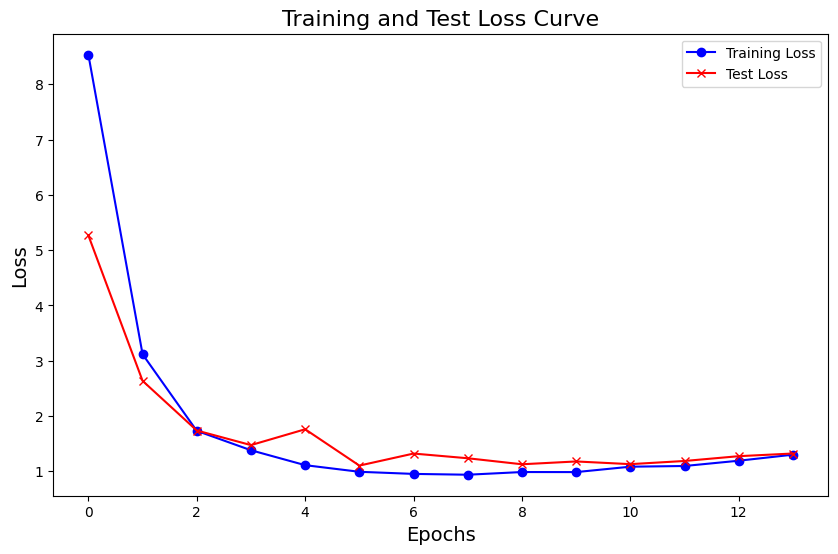

In [14]:
# 损失曲线
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses[1:], label='Training Loss', color='blue', marker='o')
plt.plot(test_losses[1:], label='Test Loss', color='red', marker='x')

plt.title('Training and Test Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
#plt.grid(True)
plt.show()

In [9]:
# 评分预测case
model.eval()
for i, (xi, xv, y) in enumerate(loader_test, 1):
    if i > 10:
        break
    with torch.no_grad():
        user_id = xv[i, 0, 0].item()  # 获取第i个样本的第一个特征（user_id）
        item_id = xv[i, 0, 1].item()  # 获取当前batch中第i个元素的item_id
        xi, xv, y = torch.squeeze(xi).to(torch.float32), torch.squeeze(xv), y.to(torch.float) 
        xi, xv, y = xi.to(device), xv.to(device), y.to(device)
        output =  model(xi, xv)
        predicted_score = output[i].item()  # 获取模型的预测评分

        print(f"Case {i}: user_id: {user_id}, item_id: {item_id}, predicted score: {predicted_score:.4f}, actual score: {y[i].item()}")

Case 1: user_id: 243, item_id: 1222, predicted score: 2.5905, actual score: 1.0
Case 2: user_id: 832, item_id: 1015, predicted score: 1.2991, actual score: 3.0
Case 3: user_id: 275, item_id: 11, predicted score: 2.3196, actual score: 4.0
Case 4: user_id: 503, item_id: 156, predicted score: 1.9544, actual score: 1.0
Case 5: user_id: 795, item_id: 687, predicted score: 2.6634, actual score: 3.0
Case 6: user_id: 311, item_id: 148, predicted score: 4.4192, actual score: 4.0
Case 7: user_id: 103, item_id: 243, predicted score: 1.2742, actual score: 1.0
Case 8: user_id: 292, item_id: 475, predicted score: 1.1766, actual score: 3.0
Case 9: user_id: 896, item_id: 527, predicted score: 3.6450, actual score: 4.0
Case 10: user_id: 513, item_id: 478, predicted score: 3.8544, actual score: 3.0


<font size="3">**4. 对比实验：Embedding+MLP**</font>

In [11]:
class EmbeddingMLP(nn.Module):
    def __init__(self, categorial_feature_vocabsize, continous_feature_names, categorial_feature_names, embed_dim, hidden_dim=[128, 64]):
        super().__init__()
        assert len(categorial_feature_vocabsize) == len(categorial_feature_names)
        # embedding layer
        self.embedding_layer_list = []
        for i in range(len(categorial_feature_vocabsize)):
            self.embedding_layer_list.append(nn.Embedding(categorial_feature_vocabsize[i], embed_dim))
        self.embedding_layer_list = nn.ModuleList(self.embedding_layer_list)
        self.mlp1 = nn.Linear(len(categorial_feature_vocabsize)*embed_dim+len(continous_feature_names), hidden_dim[0])
        self.bn1 = nn.BatchNorm1d(hidden_dim[0])
        self.relu1 = nn.ReLU(inplace=True)
        self.mlp2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.bn2 = nn.BatchNorm1d(hidden_dim[1])
        self.relu2 = nn.ReLU(inplace=True)
        self.mlp3 = nn.Linear(hidden_dim[1], 1)

    def forward(self, xi, xv):
        embed_out_list = []
        for i, embed_layer in enumerate(self.embedding_layer_list):
            embed_out = embed_layer(xv[:, i].long())
            embed_out_list.append(embed_out)
        xv = torch.cat(embed_out_list, dim=1)
        x = torch.cat((xi, xv), dim=1)
        x = self.relu1(self.bn1(self.mlp1(x)))
        x = self.relu2(self.bn2(self.mlp2(x)))
        x = self.mlp3(x)
        return x

In [12]:
def train(epoch):
    model2.train()
    running_loss = 0.0
    for step, (xi, xv, y) in enumerate(loader_train):
        xi, xv, y = torch.squeeze(xi).to(torch.float32), torch.squeeze(xv), y.to(torch.float)
        xi, xv, y = xi.to(device), xv.to(device), y.to(device)
        
        optimizer.zero_grad()
        out = model2(xi, xv)
        
        loss = nn.MSELoss()(out, y)
        #print(out, y)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if step % 200 == 0:
            print(f"epoch {epoch}, step {step}, loss {loss.item()}")
    return running_loss / len(loader_train)

def test(epoch):
    model2.eval()
    test_loss = 0.0  # cost function error
    for step, (xi, xv, y) in enumerate(loader_test):
        xi, xv, y = torch.squeeze(xi).to(torch.float32), torch.squeeze(xv), y.to(torch.float) 
        xi, xv, y = xi.to(device), xv.to(device), y.to(device)
        
        out = model2(xi, xv)
        
        test_loss += nn.MSELoss()(out, y).item()
    
    print(f"epoch {epoch}, test loss {test_loss / len(loader_test)}")
    return test_loss / len(loader_test)

In [13]:
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [14]:
#连续特征
dense_features = ['duration', 'userRatingCount', 'userAvgRating', 'userRatingStddev',
                  'movieRatingCount', 'movieAvgRating','movieRatingStddev']
#离散特征
sparse_features = ['user_id', 'item_id', 'gender', 'occupation', 'zip', 'unknown', 'Action', 'Adventure', 'Animation',
                   'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                   'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age_group', 'userRatedMovie1',
                   'userRatedMovie2', 'userRatedMovie3', 'userFavorGen1', 'userFavorGen2', 'userFavorGen3']
#离散特征词典大小
sparse_feature_vocabsize = []
with open('data/vocab_dict.json', 'r') as f:
    le_dict = json.load(f)
for k in sparse_features:
    sparse_feature_vocabsize.append(le_dict[k]+1)

# build dataset for train and test
epochs = 15
batch_size = 256
train_data = build_dataset('data/train_data_random.csv', dense_features, sparse_features)
loader_train = DataLoader(train_data, batch_size=batch_size, num_workers=16, shuffle=True, pin_memory=True)
test_data = build_dataset('data/test_data_random.csv', dense_features, sparse_features)
loader_test = DataLoader(test_data, batch_size=batch_size, num_workers=16)

torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device.".format(device))

model2 = EmbeddingMLP(sparse_feature_vocabsize, dense_features, sparse_features, embed_dim=16)
model2 = model2.to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.01, weight_decay=1e-3)
train_losses_mlp = []
test_losses_mlp = []
for ep in range(epochs):
    epoch_loss = train(ep)
    train_losses_mlp.append(epoch_loss)
    test_loss = test(ep)
    test_losses_mlp.append(test_loss)

Using cuda device.
epoch 0, step 0, loss 9.297487258911133
epoch 0, step 200, loss 0.9928267002105713
epoch 0, test loss 0.9055888230287577
epoch 1, step 0, loss 1.0167326927185059
epoch 1, step 200, loss 0.7442218661308289
epoch 1, test loss 0.8876697783228717
epoch 2, step 0, loss 1.0066859722137451
epoch 2, step 200, loss 0.8227128386497498
epoch 2, test loss 0.8682230748707735
epoch 3, step 0, loss 0.8825350403785706
epoch 3, step 200, loss 0.93868488073349
epoch 3, test loss 0.8559828219534475
epoch 4, step 0, loss 0.8680825233459473
epoch 4, step 200, loss 0.7913470268249512
epoch 4, test loss 0.8589323970335948
epoch 5, step 0, loss 0.868854820728302
epoch 5, step 200, loss 0.7731994986534119
epoch 5, test loss 0.8528168141087399
epoch 6, step 0, loss 0.7688245177268982
epoch 6, step 200, loss 0.9244722127914429
epoch 6, test loss 0.8908199713199954
epoch 7, step 0, loss 0.8850129246711731
epoch 7, step 200, loss 0.7182775735855103
epoch 7, test loss 0.8568189792995211
epoch 8, 

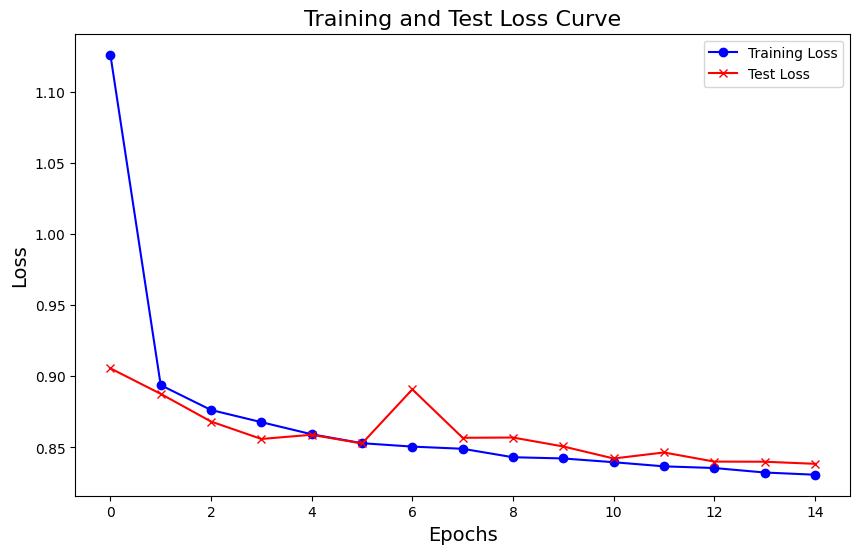

In [16]:
# 损失曲线
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses_mlp, label='Training Loss', color='blue', marker='o')
plt.plot(test_losses_mlp, label='Test Loss', color='red', marker='x')

plt.title('Training and Test Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
#plt.grid(True)
plt.show()